In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

/Users/Devansh/anaconda3/envs/data-x/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Data Cleaning

In [2]:
excel = pd.ExcelFile('HainanClean_New.xlsx')
hainan = excel.parse("fulldf")
hainan
hainan.columns = hainan.columns.str.replace('  ', '_')
hainan.columns = hainan.columns.str.replace(' ', '_')
hainan.columns = hainan.columns.str.replace('(', '')
hainan.columns = hainan.columns.str.replace('（', '')
hainan.columns = hainan.columns.str.replace(')', '')

d = {'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6,
     'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'December':12}
hainan.Month = hainan.Month.map(d)
hainan.BioCNG_Produced_Nm3 = hainan.BioCNG_Produced_m3.shift(-15)
hainan.drop(hainan.tail(15).index,inplace=True)
hainan = hainan[np.isfinite(hainan['Month'])]
hainan['BioCNG_cumsum'] = hainan.BioCNG_Produced_m3.cumsum()
hainan.columns
hainan = hainan[np.isfinite(hainan['Lemon_waste_t'])]
hainan = hainan[np.isfinite(hainan['Percolate_t'])]
hainan = hainan.replace(' ',0)
hainan = hainan.replace('',0)
hainan = hainan.replace('  ',0)
hainan = hainan.drop(['Year', 'Month', 'Day', 'Month_#', 'Day_#', 'Raw_Biogas_Produced_m3', 'BioCNG_Sold_m3', 'Vehicle_use_m3',
       'Liquid_Fertilizer_Produced_t', 'Solid_fertilizer_produced_t',
       'Wastewater_flow_to_WWTP_unit?', 'Solid_residues_kg','50%_NaOH/kg', 'FeCl2/kg', 'PAM/kg',
       'Defoamer/kg', 'Project_electricity_use/kWh',
       'Office_space_electricity_use/kWh', 'Water/m3', 'Diesel/L'], axis=1)
sumcum = hainan['BioCNG_cumsum']
hainan.drop(labels=['BioCNG_cumsum'], axis=1,inplace = True)
hainan.insert(0, 'BioCNG_cumsum', sumcum)
hainan.head()
hainan['BioCNG_Produced_m3'][760:780]

/Users/Devansh/anaconda3/envs/data-x/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  del sys.path[0]


760    2730.0
761    3147.0
764    2257.0
765    2746.0
766    2973.0
767    3085.0
768    2512.0
769    2056.0
770    2265.0
771    2802.0
772    2854.0
773    2672.0
774    3163.0
775    2513.0
776    2196.0
777    2970.0
778    2988.0
779    2953.0
780    3291.0
781    3516.0
Name: BioCNG_Produced_m3, dtype: float64

# Preliminary Work

In [3]:
hainan_train, hainan_test = train_test_split(hainan, test_size=0.2)
print('train data len:',len(hainan_train))
print('test data len:',len(hainan_test))

train data len: 1098
test data len: 275


In [4]:
#ols
hainan_ols = ols("BioCNG_cumsum ~ Pig_Manure_t + Cassava_t + Fish_waste_water_t +\
                    Kitchen_food_waste_t + Municipal_fecal_residue_t + Tea_waste_t +\
                    Chicken_litter_t + Bagasse_feed_t + Alcohol_waste_t +\
                    Chinese_medicine_waste_t + Energy_grass_t + Banana_fruit_shafts_t +\
                    Lemon_waste_t + Percolate_t + Other_waste_t", data=hainan_train).fit()
hainan_ols_summary = hainan_ols.summary()
hainan_ols_summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          BioCNG_cumsum   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     375.9
Date:                Fri, 30 Mar 2018   Prob (F-statistic):               0.00
Time:                        11:24:42   Log-Likelihood:                -16481.
No. Observations:                1098   AIC:                         3.299e+04
Df Residuals:                    1082   BIC:                         3.307e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                   1.41e+06   5.17e+04     27.287      0.000    1.31e+06    1.51e+06
Pig_Manure_t               3.068e+04   2662.722     11.523      0.000    2.55e+04    3.59e+04
Cassava_t                  -125.7933   1026.252     -0.123      0.902   -2139.462    1887.876
Fish_waste_water_t         1759.2780   4921.959      0.357      0.721   -7898.388    1.14e+04
Kitchen_food_waste_t       3.155e+04   2470.271     12.773      0.000    2.67e+04    3.64e+04
Municipal_fecal_residue_t  5593.5020    940.911      5.945      0.000    3747.285    7439.719
Tea_waste_t                2.673e+04   8675.377      3.081      0.002    9705.135    4.38e+04
Chicken_litter_t           1.455e+04   3999.415      3.638      0.000    6703.283    2.24e+04
Bagasse_feed_t            -1.445e+04   1699.377     -8.504      0.000   -1.78e+04   -1.11e+04
Alcohol_waste_t            3.504e+04   7130.571      4.913      0.000     2.1e+04     4.9e+04
Chinese_medicine_waste_t   3.427e+04   2.38e+04      1.439      0.150   -1.25e+04     8.1e+04
Energy_grass_t             3.369e+04   1.73e+04      1.946      0.052    -287.447    6.77e+04
Banana_fruit_shafts_t     -9855.1056   8604.961     -1.145      0.252   -2.67e+04    7029.196
Lemon_waste_t             -1.131e+04   2.11e+04     -0.536      0.592   -5.27e+04    3.01e+04
Percolate_t                2405.6739    294.140      8.179      0.000    1828.524    2982.824
Other_waste_t              6138.2589   2380.545      2.579      0.010    1467.252    1.08e+04
==============================================================================
Omnibus:                       36.242   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               22.255
Skew:                           0.204   Prob(JB):                     1.47e-05
Kurtosis:                       2.434   Cond. No.                         359.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#ols
hainan_ols = ols("Solid_fertilizer_produced_t ~ Pig_Manure_t + Cassava_t + Fish_waste_water_t +\
                    Kitchen_food_waste_t + Municipal_fecal_residue_t + Tea_waste_t +\
                    Chicken_litter_t + Bagasse_feed_t + Alcohol_waste_t +\
                    Chinese_medicine_waste_t + Energy_grass_t + Banana_fruit_shafts_t +\
                    Lemon_waste_t + Percolate_t + Other_waste_t", data=hainan_train).fit()
hainan_ols_summary = hainan_ols.summary()
hainan_ols_summary

From the ols results based on three different dependent variable, we can see that only the first one (cumulative sum of BioCNG) has a relatively high value for R-squared. So We decided to focus on the first one.

In [5]:
# Predict on the training data
X_train = hainan_train[['Pig_Manure_t',
       'Cassava_t', 'Fish_waste_water_t', 'Kitchen_food_waste_t',
       'Municipal_fecal_residue_t', 'Tea_waste_t', 'Chicken_litter_t',
       'Bagasse_feed_t', 'Alcohol_waste_t', 'Chinese_medicine_waste_t',
       'Energy_grass_t', 'Banana_fruit_shafts_t', 'Lemon_waste_t',
       'Percolate_t', 'Other_waste_t']]
y_train = hainan_train.BioCNG_cumsum
y_pred_train = hainan_ols.predict(X_train)

# Compute the root-mean-square of training data
rms_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
print('Training error:',rms_train/sum(y_train))

# Predict on the test data
X_test = hainan_test[['Pig_Manure_t',
       'Cassava_t', 'Fish_waste_water_t', 'Kitchen_food_waste_t',
       'Municipal_fecal_residue_t', 'Tea_waste_t', 'Chicken_litter_t',
       'Bagasse_feed_t', 'Alcohol_waste_t', 'Chinese_medicine_waste_t',
       'Energy_grass_t', 'Banana_fruit_shafts_t', 'Lemon_waste_t',
       'Percolate_t', 'Other_waste_t']]
y_test = hainan_test.BioCNG_cumsum
y_pred_test = hainan_ols.predict(X_test)

# Compute the root-mean-square of test data
rms_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print('Testing error:',rms_test/sum(y_test))

hainan_train.head()

Training error: 0.000275545254136
Testing error: 0.00106329042312


,BioCNG_cumsum,BioCNG_Produced_m3,Pig_Manure_t,Cassava_t,Fish_waste_water_t,Kitchen_food_waste_t,Municipal_fecal_residue_t,Tea_waste_t,Chicken_litter_t,Bagasse_feed_t,Alcohol_waste_t,Chinese_medicine_waste_t,Energy_grass_t,Banana_fruit_shafts_t,Lemon_waste_t,Percolate_t,Other_waste_t
710,2450382.0,5394.0,5.80,0.0,10.72,0.00,0.00,0.00,0.0,49.36,0.0,0.0,0.00,0.0,0.0,0.0,0.00
432,1394658.0,5251.0,5.30,25.0,8.32,0.00,0.00,0.00,0.0,7.00,0.0,0.0,0.62,0.0,0.0,0.0,40.34
344,988874.0,4550.0,6.10,0.0,15.92,0.00,0.00,0.00,0.0,30.60,0.0,0.0,0.00,0.0,0.0,0.0,22.86
963,3227836.0,10752.0,45.94,35.0,0.00,12.82,24.54,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,220.0,0.00
1013,3631934.0,7088.0,19.20,0.0,0.00,15.68,57.42,7.88,0.0,25.00,0.0,0.0,0.00,0.0,0.0,169.0,0.00


# Training Algorithms

1. Logistic regression
2. SVM
3. Perceptron
4. kNN
5. Random Forest
6. xgBoost

In [6]:
#logistic regression
hainan['BioCNG_cumsum'] = pd.cut(hainan['BioCNG_cumsum'], bins=3, labels=[0, 1, 2])
hainan_train, hainan_test = train_test_split(hainan, test_size=0.2)
y_train = hainan_train.BioCNG_cumsum
y_test = hainan_test.BioCNG_cumsum
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_test = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on train set: {:.2f}'.format(logreg.score(X_train, y_train)))
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred_test)
print(confusion_matrix)

Accuracy of logistic regression classifier on train set: 0.52
Accuracy of logistic regression classifier on test set: 0.52
[[144   1   0]
 [ 93   0   0]
 [ 36   1   0]]


In [7]:
# SVM
from sklearn import svm
clf = svm.SVC()
clf.fit(X_train, y_train)  
y_pred_test = clf.predict(X_test)
print('Accuracy of SVM on train set: {:.2f}'.format(clf.score(X_train, y_train)))
print('Accuracy of SVM on test set: {:.2f}'.format(clf.score(X_test, y_test)))

Accuracy of SVM on train set: 0.85
Accuracy of SVM on test set: 0.52


In [8]:
# kNN
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=4)
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(hainan[['BioCNG_cumsum', 'Pig_Manure_t',
       'Cassava_t', 'Fish_waste_water_t', 'Kitchen_food_waste_t',
       'Municipal_fecal_residue_t', 'Tea_waste_t', 'Chicken_litter_t',
       'Bagasse_feed_t', 'Alcohol_waste_t', 'Chinese_medicine_waste_t',
       'Energy_grass_t', 'Banana_fruit_shafts_t', 'Lemon_waste_t',
       'Percolate_t', 'Other_waste_t']])
hainan_normalized = pd.DataFrame(np_scaled)
hainan_normalized_train, hainan_normalized_test = train_test_split(hainan_normalized, test_size=0.2)
hainan_normalized
Xnor_train = hainan_normalized_train.iloc[:, 1:16]    
ynor_train = hainan_normalized_train[0]
Xnor_test = hainan_normalized_test.iloc[:, 1:16]
ynor_test = hainan_normalized_test[0]
knn.fit(Xnor_train, ynor_train)
y_pred_test = knn.predict(Xnor_test)
print('Accuracy of kNN on train set: {:.2f}'.format(knn.score(Xnor_train, ynor_train)))
print('Accuracy of kNN on test set: {:.2f}'.format(knn.score(Xnor_test, ynor_test)))


Accuracy of kNN on train set: 0.88
Accuracy of kNN on test set: 0.83


In [9]:
# xgboost
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred_test = xgb.predict(X_test)
print('Accuracy of XGboost on train set: {:.2f}'.format(xgb.score(X_train, y_train)))
print('Accuracy of XGboost on test set: {:.2f}'.format(xgb.score(X_test, y_test)))
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred_test)
print(confusion_matrix)

/Users/Devansh/anaconda3/envs/data-x/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Accuracy of XGboost on train set: 0.62
Accuracy of XGboost on test set: 0.51
[[132  13   0]
 [ 86   7   0]
 [ 34   3   0]]


In [10]:
# random forest
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators = 1000)
random_forest.fit(X_train, y_train)
print('Accuracy of Random Forest on train set: {:.2f}'.format(random_forest.score(X_train, y_train)))
print('Accuracy of Random Forest on test set: {:.2f}'.format(random_forest.score(X_test, y_test)))

Accuracy of Random Forest on train set: 0.97
Accuracy of Random Forest on test set: 0.47


From the accuracy results of the above algorithms training, we can see that except for kNN, all of them have relatively good results for accuracy around 0.5.

# Trying with 1/x

In [11]:
hainan

,BioCNG_cumsum,BioCNG_Produced_m3,Pig_Manure_t,Cassava_t,Fish_waste_water_t,Kitchen_food_waste_t,Municipal_fecal_residue_t,Tea_waste_t,Chicken_litter_t,Bagasse_feed_t,Alcohol_waste_t,Chinese_medicine_waste_t,Energy_grass_t,Banana_fruit_shafts_t,Lemon_waste_t,Percolate_t,Other_waste_t
0,0,2024.0,6.82,0.0,0.00,0.00,0.000,0.00,0.00,15.00,0.0,0.0,0.0,0.0,0.00,0.0,26.44
1,0,2909.0,0.00,0.0,0.00,0.00,0.000,0.00,0.00,15.00,0.0,0.0,0.0,0.0,0.00,0.0,28.92
2,0,3020.0,6.66,0.0,0.00,0.00,0.000,0.00,0.00,15.00,0.0,0.0,0.0,0.0,0.00,0.0,26.90
3,0,3042.0,12.50,0.0,0.00,0.00,0.000,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00
4,0,2779.0,9.54,0.0,0.00,0.00,0.000,0.00,0.00,9.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00
5,0,2686.0,2.98,0.0,0.00,0.00,0.000,0.00,0.00,13.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00
6,0,2112.0,6.04,0.0,0.00,0.00,0.000,0.00,0.00,6.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00
7,0,1529.0,15.36,0.0,0.00,0.00,0.000,0.00,0.00,9.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00
8,0,2085.0,6.30,0.0,0.00,0.00,0.000,0.00,0.00,15.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00
9,0,1902.0,7.00,0.0,0.00,0.00,0.000,0.00,0.00,15.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00


In [12]:
for col in hainan.columns[2:]:
    hainan['1/'+col] = 1/(hainan[col])
hainan.head()
hainan.columns

Index(['BioCNG_cumsum', 'BioCNG_Produced_m3', 'Pig_Manure_t', 'Cassava_t',
       'Fish_waste_water_t', 'Kitchen_food_waste_t',
       'Municipal_fecal_residue_t', 'Tea_waste_t', 'Chicken_litter_t',
       'Bagasse_feed_t', 'Alcohol_waste_t', 'Chinese_medicine_waste_t',
       'Energy_grass_t', 'Banana_fruit_shafts_t', 'Lemon_waste_t',
       'Percolate_t', 'Other_waste_t', '1/Pig_Manure_t', '1/Cassava_t',
       '1/Fish_waste_water_t', '1/Kitchen_food_waste_t',
       '1/Municipal_fecal_residue_t', '1/Tea_waste_t', '1/Chicken_litter_t',
       '1/Bagasse_feed_t', '1/Alcohol_waste_t', '1/Chinese_medicine_waste_t',
       '1/Energy_grass_t', '1/Banana_fruit_shafts_t', '1/Lemon_waste_t',
       '1/Percolate_t', '1/Other_waste_t'],
      dtype='object')

In [13]:
hainan.head()

,BioCNG_cumsum,BioCNG_Produced_m3,Pig_Manure_t,Cassava_t,Fish_waste_water_t,Kitchen_food_waste_t,Municipal_fecal_residue_t,Tea_waste_t,Chicken_litter_t,Bagasse_feed_t,...,1/Tea_waste_t,1/Chicken_litter_t,1/Bagasse_feed_t,1/Alcohol_waste_t,1/Chinese_medicine_waste_t,1/Energy_grass_t,1/Banana_fruit_shafts_t,1/Lemon_waste_t,1/Percolate_t,1/Other_waste_t
0,0,2024.0,6.82,0.0,0.0,0.0,0.0,0.0,0.0,15.0,...,inf,inf,0.066667,inf,inf,inf,inf,inf,inf,0.037821
1,0,2909.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,15.0,...,inf,inf,0.066667,inf,inf,inf,inf,inf,inf,0.034578
2,0,3020.0,6.66,0.0,0.0,0.0,0.0,0.0,0.0,15.0,...,inf,inf,0.066667,inf,inf,inf,inf,inf,inf,0.037175
3,0,3042.0,12.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
4,0,2779.0,9.54,0.0,0.0,0.0,0.0,0.0,0.0,9.0,...,inf,inf,0.111111,inf,inf,inf,inf,inf,inf,inf


In [14]:
hainan.replace(float('inf'),0, inplace = True);
hainan_train, hainan_test = train_test_split(hainan, test_size=0.2)
print('train data len:',len(hainan_train))
print('test data len:',len(hainan_test))
hainan.head()

train data len: 1098
test data len: 275


,BioCNG_cumsum,BioCNG_Produced_m3,Pig_Manure_t,Cassava_t,Fish_waste_water_t,Kitchen_food_waste_t,Municipal_fecal_residue_t,Tea_waste_t,Chicken_litter_t,Bagasse_feed_t,...,1/Tea_waste_t,1/Chicken_litter_t,1/Bagasse_feed_t,1/Alcohol_waste_t,1/Chinese_medicine_waste_t,1/Energy_grass_t,1/Banana_fruit_shafts_t,1/Lemon_waste_t,1/Percolate_t,1/Other_waste_t
0,0,2024.0,6.82,0.0,0.0,0.0,0.0,0.0,0.0,15.0,...,0.0,0.0,0.066667,0.0,0.0,0.0,0.0,0.0,0.0,0.037821
1,0,2909.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,15.0,...,0.0,0.0,0.066667,0.0,0.0,0.0,0.0,0.0,0.0,0.034578
2,0,3020.0,6.66,0.0,0.0,0.0,0.0,0.0,0.0,15.0,...,0.0,0.0,0.066667,0.0,0.0,0.0,0.0,0.0,0.0,0.037175
3,0,3042.0,12.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0,2779.0,9.54,0.0,0.0,0.0,0.0,0.0,0.0,9.0,...,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [15]:
# Predict on the training data
X_train = hainan_train[['BioCNG_cumsum', 'BioCNG_Produced_m3', 'Pig_Manure_t', 'Cassava_t',
       'Fish_waste_water_t', 'Kitchen_food_waste_t',
       'Municipal_fecal_residue_t', 'Tea_waste_t', 'Chicken_litter_t',
       'Bagasse_feed_t', 'Alcohol_waste_t', 'Chinese_medicine_waste_t',
       'Energy_grass_t', 'Banana_fruit_shafts_t', 'Lemon_waste_t',
       'Percolate_t', 'Other_waste_t', '1/Pig_Manure_t', '1/Cassava_t',
       '1/Fish_waste_water_t', '1/Kitchen_food_waste_t',
       '1/Municipal_fecal_residue_t', '1/Tea_waste_t', '1/Chicken_litter_t',
       '1/Bagasse_feed_t', '1/Alcohol_waste_t', '1/Chinese_medicine_waste_t',
       '1/Energy_grass_t', '1/Banana_fruit_shafts_t', '1/Lemon_waste_t',
       '1/Percolate_t', '1/Other_waste_t']]
y_train = hainan_train.BioCNG_cumsum
y_pred_train = hainan_ols.predict(X_train)

# Compute the root-mean-square of training data
rms_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
print('Training error:',rms_train/sum(y_train))

# Predict on the test data
X_test = hainan_test[['BioCNG_cumsum', 'BioCNG_Produced_m3', 'Pig_Manure_t', 'Cassava_t',
       'Fish_waste_water_t', 'Kitchen_food_waste_t',
       'Municipal_fecal_residue_t', 'Tea_waste_t', 'Chicken_litter_t',
       'Bagasse_feed_t', 'Alcohol_waste_t', 'Chinese_medicine_waste_t',
       'Energy_grass_t', 'Banana_fruit_shafts_t', 'Lemon_waste_t',
       'Percolate_t', 'Other_waste_t', '1/Pig_Manure_t', '1/Cassava_t',
       '1/Fish_waste_water_t', '1/Kitchen_food_waste_t',
       '1/Municipal_fecal_residue_t', '1/Tea_waste_t', '1/Chicken_litter_t',
       '1/Bagasse_feed_t', '1/Alcohol_waste_t', '1/Chinese_medicine_waste_t',
       '1/Energy_grass_t', '1/Banana_fruit_shafts_t', '1/Lemon_waste_t',
       '1/Percolate_t', '1/Other_waste_t']]
y_test = hainan_test.BioCNG_cumsum
y_pred_test = hainan_ols.predict(X_test)

# Compute the root-mean-square of test data
rms_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print('Testing error:',rms_test/sum(y_test))

hainan_train.head()

Training error: 4497.44269158
Testing error: 19977.7512646


,BioCNG_cumsum,BioCNG_Produced_m3,Pig_Manure_t,Cassava_t,Fish_waste_water_t,Kitchen_food_waste_t,Municipal_fecal_residue_t,Tea_waste_t,Chicken_litter_t,Bagasse_feed_t,...,1/Tea_waste_t,1/Chicken_litter_t,1/Bagasse_feed_t,1/Alcohol_waste_t,1/Chinese_medicine_waste_t,1/Energy_grass_t,1/Banana_fruit_shafts_t,1/Lemon_waste_t,1/Percolate_t,1/Other_waste_t
796,1,2308.0,5.48,0.0,0.0,0.00,0.00,0.0,0.00,0.00,...,0.0,0.000000,0.000000,0.084459,0.0,0.0,0.0,0.0,0.000000,0.000000
1,0,2909.0,0.00,0.0,0.0,0.00,0.00,0.0,0.00,15.00,...,0.0,0.000000,0.066667,0.000000,0.0,0.0,0.0,0.0,0.000000,0.034578
487,0,2252.0,10.30,0.0,0.0,0.00,0.00,0.0,0.00,22.68,...,0.0,0.000000,0.044092,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
74,0,4161.0,11.98,0.0,0.0,0.00,0.00,0.0,0.00,40.00,...,0.0,0.000000,0.025000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
1323,2,13128.0,30.96,0.0,0.0,40.56,92.06,0.0,33.72,0.00,...,0.0,0.029656,0.000000,0.000000,0.0,0.0,0.0,0.0,0.003597,0.000000


In [16]:
#logistic regression
hainan['BioCNG_cumsum'] = pd.cut(hainan['BioCNG_cumsum'], bins=3, labels=[0, 1, 2])
hainan_train, hainan_test = train_test_split(hainan, test_size=0.2)
y_train = hainan_train.BioCNG_cumsum
y_test = hainan_test.BioCNG_cumsum
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_test = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on train set: {:.2f}'.format(logreg.score(X_train, y_train)))
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred_test)
print(confusion_matrix)

Accuracy of logistic regression classifier on train set: 0.52
Accuracy of logistic regression classifier on test set: 0.50
[[137   7   5]
 [ 86   0   0]
 [ 38   2   0]]


In [17]:
# SVM
from sklearn import svm
clf = svm.SVC()
clf.fit(X_train, y_train)  
y_pred_test = clf.predict(X_test)
print('Accuracy of SVM on train set: {:.2f}'.format(clf.score(X_train, y_train)))
print('Accuracy of SVM on test set: {:.2f}'.format(clf.score(X_test, y_test)))

Accuracy of SVM on train set: 0.99
Accuracy of SVM on test set: 0.53


In [18]:
# perceptron
from sklearn.linear_model import perceptron
net = perceptron.Perceptron(n_iter=100, verbose=0, random_state=None, fit_intercept=True, eta0=0.002)
net.fit(X_train, y_train)
y_pred_test = net.predict(X_test)
print('Accuracy of perceptron on train set: {:.2f}'.format(net.score(X_train, y_train)))
print('Accuracy of perceptron on test set: {:.2f}'.format(net.score(X_test, y_test)))

Accuracy of perceptron on train set: 0.33
Accuracy of perceptron on test set: 0.32


/Users/Devansh/anaconda3/envs/data-x/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


In [19]:
# kNN
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=4)
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(hainan[['BioCNG_cumsum', 'BioCNG_Produced_m3', 'Pig_Manure_t', 'Cassava_t',
       'Fish_waste_water_t', 'Kitchen_food_waste_t',
       'Municipal_fecal_residue_t', 'Tea_waste_t', 'Chicken_litter_t',
       'Bagasse_feed_t', 'Alcohol_waste_t', 'Chinese_medicine_waste_t',
       'Energy_grass_t', 'Banana_fruit_shafts_t', 'Lemon_waste_t',
       'Percolate_t', 'Other_waste_t', '1/Pig_Manure_t', '1/Cassava_t',
       '1/Fish_waste_water_t', '1/Kitchen_food_waste_t',
       '1/Municipal_fecal_residue_t', '1/Tea_waste_t', '1/Chicken_litter_t',
       '1/Bagasse_feed_t', '1/Alcohol_waste_t', '1/Chinese_medicine_waste_t',
       '1/Energy_grass_t', '1/Banana_fruit_shafts_t', '1/Lemon_waste_t',
       '1/Percolate_t', '1/Other_waste_t']])
hainan_normalized = pd.DataFrame(np_scaled)
hainan_normalized_train, hainan_normalized_test = train_test_split(hainan_normalized, test_size=0.2)
hainan_normalized
Xnor_train = hainan_normalized_train.iloc[:, 1:16]    
ynor_train = hainan_normalized_train[0]
Xnor_test = hainan_normalized_test.iloc[:, 1:16]
ynor_test = hainan_normalized_test[0]
knn.fit(Xnor_train, ynor_train)
y_pred_test = knn.predict(Xnor_test)
print('Accuracy of kNN on train set: {:.2f}'.format(knn.score(Xnor_train, ynor_train)))
print('Accuracy of kNN on test set: {:.2f}'.format(knn.score(Xnor_test, ynor_test)))


Accuracy of kNN on train set: 0.89
Accuracy of kNN on test set: 0.79


In [20]:
# random forest
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators = 1000)
random_forest.fit(X_train, y_train)
print('Accuracy of Random Forest on train set: {:.2f}'.format(random_forest.score(X_train, y_train)))
print('Accuracy of Random Forest on test set: {:.2f}'.format(random_forest.score(X_test, y_test)))

Accuracy of Random Forest on train set: 0.99
Accuracy of Random Forest on test set: 0.45


# Trying with x^2

In [21]:
for col in hainan.columns[2:]:
    hainan[col+"**2"] = (hainan[col])**2
hainan.head()

,BioCNG_cumsum,BioCNG_Produced_m3,Pig_Manure_t,Cassava_t,Fish_waste_water_t,Kitchen_food_waste_t,Municipal_fecal_residue_t,Tea_waste_t,Chicken_litter_t,Bagasse_feed_t,...,1/Tea_waste_t**2,1/Chicken_litter_t**2,1/Bagasse_feed_t**2,1/Alcohol_waste_t**2,1/Chinese_medicine_waste_t**2,1/Energy_grass_t**2,1/Banana_fruit_shafts_t**2,1/Lemon_waste_t**2,1/Percolate_t**2,1/Other_waste_t**2
0,0,2024.0,6.82,0.0,0.0,0.0,0.0,0.0,0.0,15.0,...,0.0,0.0,0.004444,0.0,0.0,0.0,0.0,0.0,0.0,0.001430
1,0,2909.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,15.0,...,0.0,0.0,0.004444,0.0,0.0,0.0,0.0,0.0,0.0,0.001196
2,0,3020.0,6.66,0.0,0.0,0.0,0.0,0.0,0.0,15.0,...,0.0,0.0,0.004444,0.0,0.0,0.0,0.0,0.0,0.0,0.001382
3,0,3042.0,12.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0,2779.0,9.54,0.0,0.0,0.0,0.0,0.0,0.0,9.0,...,0.0,0.0,0.012346,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [22]:
hainan_train, hainan_test = train_test_split(hainan, test_size=0.2)
print('train data len:',len(hainan_train))
print('test data len:',len(hainan_test))
hainan.head()
hainan.columns

train data len: 1098
test data len: 275


Index(['BioCNG_cumsum', 'BioCNG_Produced_m3', 'Pig_Manure_t', 'Cassava_t',
       'Fish_waste_water_t', 'Kitchen_food_waste_t',
       'Municipal_fecal_residue_t', 'Tea_waste_t', 'Chicken_litter_t',
       'Bagasse_feed_t', 'Alcohol_waste_t', 'Chinese_medicine_waste_t',
       'Energy_grass_t', 'Banana_fruit_shafts_t', 'Lemon_waste_t',
       'Percolate_t', 'Other_waste_t', '1/Pig_Manure_t', '1/Cassava_t',
       '1/Fish_waste_water_t', '1/Kitchen_food_waste_t',
       '1/Municipal_fecal_residue_t', '1/Tea_waste_t', '1/Chicken_litter_t',
       '1/Bagasse_feed_t', '1/Alcohol_waste_t', '1/Chinese_medicine_waste_t',
       '1/Energy_grass_t', '1/Banana_fruit_shafts_t', '1/Lemon_waste_t',
       '1/Percolate_t', '1/Other_waste_t', 'Pig_Manure_t**2', 'Cassava_t**2',
       'Fish_waste_water_t**2', 'Kitchen_food_waste_t**2',
       'Municipal_fecal_residue_t**2', 'Tea_waste_t**2', 'Chicken_litter_t**2',
       'Bagasse_feed_t**2', 'Alcohol_waste_t**2',
       'Chinese_medicine_waste_t**2', 

In [23]:
# Predict on the training data
X_train = hainan_train[['Pig_Manure_t', 'Cassava_t',
       'Fish_waste_water_t', 'Kitchen_food_waste_t',
       'Municipal_fecal_residue_t', 'Tea_waste_t', 'Chicken_litter_t',
       'Bagasse_feed_t', 'Alcohol_waste_t', 'Chinese_medicine_waste_t',
       'Energy_grass_t', 'Banana_fruit_shafts_t', 'Lemon_waste_t',
       'Percolate_t', 'Other_waste_t', '1/Pig_Manure_t', '1/Cassava_t',
       '1/Fish_waste_water_t', '1/Kitchen_food_waste_t',
       '1/Municipal_fecal_residue_t', '1/Tea_waste_t', '1/Chicken_litter_t',
       '1/Bagasse_feed_t', '1/Alcohol_waste_t', '1/Chinese_medicine_waste_t',
       '1/Energy_grass_t', '1/Banana_fruit_shafts_t', '1/Lemon_waste_t',
       '1/Percolate_t', '1/Other_waste_t', 'Pig_Manure_t**2', 'Cassava_t**2',
       'Fish_waste_water_t**2', 'Kitchen_food_waste_t**2',
       'Municipal_fecal_residue_t**2', 'Tea_waste_t**2', 'Chicken_litter_t**2',
       'Bagasse_feed_t**2', 'Alcohol_waste_t**2',
       'Chinese_medicine_waste_t**2', 'Energy_grass_t**2',
       'Banana_fruit_shafts_t**2', 'Lemon_waste_t**2', 'Percolate_t**2',
       'Other_waste_t**2', '1/Pig_Manure_t**2', '1/Cassava_t**2',
       '1/Fish_waste_water_t**2', '1/Kitchen_food_waste_t**2',
       '1/Municipal_fecal_residue_t**2', '1/Tea_waste_t**2',
       '1/Chicken_litter_t**2', '1/Bagasse_feed_t**2', '1/Alcohol_waste_t**2',
       '1/Chinese_medicine_waste_t**2', '1/Energy_grass_t**2',
       '1/Banana_fruit_shafts_t**2', '1/Lemon_waste_t**2', '1/Percolate_t**2',
       '1/Other_waste_t**2']]
y_train = hainan_train.BioCNG_cumsum
y_pred_train = hainan_ols.predict(X_train)

# Predict on the test data
X_test = hainan_test[['Pig_Manure_t', 'Cassava_t',
       'Fish_waste_water_t', 'Kitchen_food_waste_t',
       'Municipal_fecal_residue_t', 'Tea_waste_t', 'Chicken_litter_t',
       'Bagasse_feed_t', 'Alcohol_waste_t', 'Chinese_medicine_waste_t',
       'Energy_grass_t', 'Banana_fruit_shafts_t', 'Lemon_waste_t',
       'Percolate_t', 'Other_waste_t', '1/Pig_Manure_t', '1/Cassava_t',
       '1/Fish_waste_water_t', '1/Kitchen_food_waste_t',
       '1/Municipal_fecal_residue_t', '1/Tea_waste_t', '1/Chicken_litter_t',
       '1/Bagasse_feed_t', '1/Alcohol_waste_t', '1/Chinese_medicine_waste_t',
       '1/Energy_grass_t', '1/Banana_fruit_shafts_t', '1/Lemon_waste_t',
       '1/Percolate_t', '1/Other_waste_t', 'Pig_Manure_t**2', 'Cassava_t**2',
       'Fish_waste_water_t**2', 'Kitchen_food_waste_t**2',
       'Municipal_fecal_residue_t**2', 'Tea_waste_t**2', 'Chicken_litter_t**2',
       'Bagasse_feed_t**2', 'Alcohol_waste_t**2',
       'Chinese_medicine_waste_t**2', 'Energy_grass_t**2',
       'Banana_fruit_shafts_t**2', 'Lemon_waste_t**2', 'Percolate_t**2',
       'Other_waste_t**2', '1/Pig_Manure_t**2', '1/Cassava_t**2',
       '1/Fish_waste_water_t**2', '1/Kitchen_food_waste_t**2',
       '1/Municipal_fecal_residue_t**2', '1/Tea_waste_t**2',
       '1/Chicken_litter_t**2', '1/Bagasse_feed_t**2', '1/Alcohol_waste_t**2',
       '1/Chinese_medicine_waste_t**2', '1/Energy_grass_t**2',
       '1/Banana_fruit_shafts_t**2', '1/Lemon_waste_t**2', '1/Percolate_t**2',
       '1/Other_waste_t**2']]
y_test = hainan_test.BioCNG_cumsum
y_pred_test = hainan_ols.predict(X_test)


In [24]:
#logistic regression
hainan['BioCNG_cumsum'] = pd.cut(hainan['BioCNG_cumsum'], bins=3, labels=[0, 1, 2])
hainan_train, hainan_test = train_test_split(hainan, test_size=0.2)
y_train = hainan_train.BioCNG_cumsum
y_test = hainan_test.BioCNG_cumsum
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_test = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on train set: {:.2f}'.format(logreg.score(X_train, y_train)))
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred_test)
print(confusion_matrix)

Accuracy of logistic regression classifier on train set: 0.52
Accuracy of logistic regression classifier on test set: 0.51
[[133  11   1]
 [ 83   6   0]
 [ 36   5   0]]


In [25]:
# SVM
from sklearn import svm
clf = svm.SVC()
clf.fit(X_train, y_train)  
y_pred_test = clf.predict(X_test)
print('Accuracy of SVM on train set: {:.2f}'.format(clf.score(X_train, y_train)))
print('Accuracy of SVM on test set: {:.2f}'.format(clf.score(X_test, y_test)))

Accuracy of SVM on train set: 0.93
Accuracy of SVM on test set: 0.52


In [26]:
# perceptron
from sklearn.linear_model import perceptron
net = perceptron.Perceptron(n_iter=100, verbose=0, random_state=None, fit_intercept=True, eta0=0.002)
net.fit(X_train, y_train)
y_pred_test = net.predict(X_test)
print('Accuracy of perceptron on train set: {:.2f}'.format(net.score(X_train, y_train)))
print('Accuracy of perceptron on test set: {:.2f}'.format(net.score(X_test, y_test)))

Accuracy of perceptron on train set: 0.45
Accuracy of perceptron on test set: 0.45


/Users/Devansh/anaconda3/envs/data-x/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


In [27]:
# kNN
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=4)
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(hainan[['BioCNG_cumsum', 'Pig_Manure_t', 'Cassava_t',
       'Fish_waste_water_t', 'Kitchen_food_waste_t',
       'Municipal_fecal_residue_t', 'Tea_waste_t', 'Chicken_litter_t',
       'Bagasse_feed_t', 'Alcohol_waste_t', 'Chinese_medicine_waste_t',
       'Energy_grass_t', 'Banana_fruit_shafts_t', 'Lemon_waste_t',
       'Percolate_t', 'Other_waste_t', '1/Pig_Manure_t', '1/Cassava_t',
       '1/Fish_waste_water_t', '1/Kitchen_food_waste_t',
       '1/Municipal_fecal_residue_t', '1/Tea_waste_t', '1/Chicken_litter_t',
       '1/Bagasse_feed_t', '1/Alcohol_waste_t', '1/Chinese_medicine_waste_t',
       '1/Energy_grass_t', '1/Banana_fruit_shafts_t', '1/Lemon_waste_t',
       '1/Percolate_t', '1/Other_waste_t', 'Pig_Manure_t**2', 'Cassava_t**2',
       'Fish_waste_water_t**2', 'Kitchen_food_waste_t**2',
       'Municipal_fecal_residue_t**2', 'Tea_waste_t**2', 'Chicken_litter_t**2',
       'Bagasse_feed_t**2', 'Alcohol_waste_t**2',
       'Chinese_medicine_waste_t**2', 'Energy_grass_t**2',
       'Banana_fruit_shafts_t**2', 'Lemon_waste_t**2', 'Percolate_t**2',
       'Other_waste_t**2', '1/Pig_Manure_t**2', '1/Cassava_t**2',
       '1/Fish_waste_water_t**2', '1/Kitchen_food_waste_t**2',
       '1/Municipal_fecal_residue_t**2', '1/Tea_waste_t**2',
       '1/Chicken_litter_t**2', '1/Bagasse_feed_t**2', '1/Alcohol_waste_t**2',
       '1/Chinese_medicine_waste_t**2', '1/Energy_grass_t**2',
       '1/Banana_fruit_shafts_t**2', '1/Lemon_waste_t**2', '1/Percolate_t**2',
       '1/Other_waste_t**2']])
hainan_normalized = pd.DataFrame(np_scaled)
hainan_normalized_train, hainan_normalized_test = train_test_split(hainan_normalized, test_size=0.2)
hainan_normalized
Xnor_train = hainan_normalized_train.iloc[:, 1:60]    
ynor_train = hainan_normalized_train[0]
Xnor_test = hainan_normalized_test.iloc[:, 1:60]
ynor_test = hainan_normalized_test[0]
knn.fit(Xnor_train, ynor_train)
y_pred_test = knn.predict(Xnor_test)
print('Accuracy of kNN on train set: {:.2f}'.format(knn.score(Xnor_train, ynor_train)))
print('Accuracy of kNN on test set: {:.2f}'.format(knn.score(Xnor_test, ynor_test)))


Accuracy of kNN on train set: 0.88
Accuracy of kNN on test set: 0.76


In [28]:
# random forest
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators = 1000)
random_forest.fit(X_train, y_train)
print('Accuracy of Random Forest on train set: {:.2f}'.format(random_forest.score(X_train, y_train)))
print('Accuracy of Random Forest on test set: {:.2f}'.format(random_forest.score(X_test, y_test)))

Accuracy of Random Forest on train set: 0.97
Accuracy of Random Forest on test set: 0.47


# Regularisation

In [66]:
c_val = [1e-20, 1e-8, 1e-3,1e-2, 1, 10, 20, 30, 50, 1000]

In [75]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix

skf = StratifiedKFold(n_splits=4)

col = ['cross_Val_score', 'intercept'] + [i for i in hainan.columns if i not in hainan.columns[0:2]]

ind = ['c_val_%.2g'%c_val[i] for i in range(0,10)]
coef_matrix_logreg = pd.DataFrame(index=ind, columns=col)

for i, idx in enumerate(c_val):
    ret = np.zeros((1,62))
    logreg = LogisticRegression(penalty = 'l2', C = c_val[i], max_iter = 100)
    rss = []
    cross_valscore = []
    confusion_mat = []
    for train, test in skf.split(X_train, y_train):
        
        cross_valscore.append(([logreg.fit(X_train.iloc[train], y_train.iloc[train]).score(X_train.iloc[test], y_train.iloc[test])]))
        
    ret[0,0] = np.mean(cross_valscore)
    ret[0, 1] = logreg.intercept_[0]
    ret[0, 2:62] = logreg.coef_[0:61][1]
    coef_matrix_logreg.iloc[i,] = ret

,cross_Val_score,intercept,Pig_Manure_t,Cassava_t,Fish_waste_water_t,Kitchen_food_waste_t,Municipal_fecal_residue_t,Tea_waste_t,Chicken_litter_t,Bagasse_feed_t,...,1/Tea_waste_t**2,1/Chicken_litter_t**2,1/Bagasse_feed_t**2,1/Alcohol_waste_t**2,1/Chinese_medicine_waste_t**2,1/Energy_grass_t**2,1/Banana_fruit_shafts_t**2,1/Lemon_waste_t**2,1/Percolate_t**2,1/Other_waste_t**2
c_val_1e-20,0.520956,1.75e-19,-1.85336e-17,-1.96948e-17,-2.0719e-18,-2.17124e-17,-3.96634e-17,-1.1911e-18,-9.9347e-18,-1.41941e-17,...,-9.63817e-21,-9.88775e-22,-5.61585e-20,-4.27003e-22,-1.40549e-21,1.14004e-20,-3.16025e-22,-1.80444e-21,-3.15612e-22,-2.49064e-18
c_val_1e-08,0.518242,6.68496e-08,-6.77621e-06,-4.30932e-06,-1.17605e-06,-2.26019e-06,-5.40771e-06,-3.7046e-07,-1.86787e-06,-7.61408e-06,...,-6.4392e-09,1.44872e-11,-1.39022e-08,-3.43289e-10,4.50413e-10,2.65206e-08,7.06574e-10,2.01514e-10,-2.44683e-10,-2.42768e-06
c_val_0.001,0.494628,0.00477848,-0.0175913,-0.0131168,0.00329775,-0.00981335,-0.00535885,0.00522325,0.00432058,-0.0262886,...,-0.000232857,-5.13609e-07,-0.000296318,5.72934e-06,9.33873e-05,0.00329803,7.07707e-05,3.31432e-05,-1.11189e-05,-0.00254932
c_val_0.01,0.496453,0.0110195,-0.0157899,-0.0151584,0.00834006,-0.0160682,-0.00458356,0.0127752,0.00807966,-0.0255721,...,-0.000590312,-1.22834e-06,-0.000709643,1.57034e-05,0.000230623,0.00564037,0.000175178,8.23956e-05,-2.72361e-05,-0.00281869
c_val_1,0.496463,0.0608447,0.00130199,-0.0165254,0.0158892,-0.0123221,-0.00502534,0.0397889,0.00749047,-0.0213925,...,-0.00261576,-9.79545e-06,-0.00210701,6.99537e-05,0.000957672,0.00662484,0.000690069,0.000328999,-0.000110486,-0.00354486
c_val_10,0.490086,0.00472089,0.00549808,-0.0102441,0.0270577,-0.0107453,-0.00444738,0.0594495,0.00013503,-0.0127893,...,-0.00689084,-5.71147e-05,-0.000967222,0.000168655,0.00240457,0.0079672,0.0016156,0.000768078,-0.000273075,-0.00485819
c_val_20,0.492813,0.0460069,0.0110205,-0.0121514,0.028504,-0.012376,-0.00278604,0.0624048,0.0011743,-0.0124747,...,-0.0076898,-6.46518e-05,-0.000608452,0.000186414,0.00269503,0.0073276,0.00178532,0.000848567,-0.000302976,-0.00570547
c_val_30,0.49282,0.044125,0.0250481,-0.0108344,0.0473074,-0.0137893,-0.0022089,0.07137,-0.000938076,-0.00316221,...,-0.0167093,-0.000221422,0.010967,0.000357778,0.00577009,0.0043578,0.00358981,0.00167233,-0.000631679,-0.00843888
c_val_50,0.491898,0.119529,-0.0146179,-0.0143502,0.0105849,-0.0169764,-0.00405381,0.0191775,0.00905282,-0.0242162,...,-0.00094229,-2.1411e-06,-0.001075,2.54724e-05,0.000361349,0.00622316,0.000272526,0.000128592,-4.24206e-05,-0.00281602
c_val_1e+03,0.498271,0.0360188,-0.00943941,-0.0141565,0.0143789,-0.0174806,-0.00377378,0.033592,0.00716898,-0.0215425,...,-0.00195052,-5.65374e-06,-0.00185611,5.27329e-05,0.000727863,0.00659501,0.000532078,0.000253024,-8.44612e-05,-0.00311337


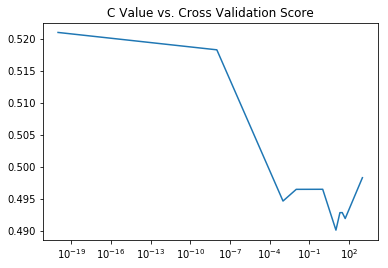

In [71]:
plt.semilogx(c_val, coef_matrix_logreg['cross_Val_score'])
plt.title('C Value vs. Cross Validation Score')
coef_matrix_logreg